## Development of Deep Learning Model for Face Recognition in Security Systems

**Author :** Husain Ahmad Faiq

In [1]:
import os
import cv2
import itertools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

from tensorflow import keras
from keras import regularizers
from keras.models import load_model
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.layers import Dense, Activation, Dropout

In [2]:

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=3000)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPUs


## 1. Pre-Processing Images

### 1.1 Taking Pictures for Dataset

In [44]:
cap = cv2.VideoCapture(0)

dataset_folder = "dataset/"

name = "Husain_Ahmad_Faiq"

if not os.path.exists(dataset_folder + name):
    os.mkdir(dataset_folder + name)
num_existing_samples = len(os.listdir(dataset_folder + name))
num_sample = 50
i = 0
while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        cv2.imshow("Capture Photo", frame)
        cv2.imwrite("dataset/%s/%s_%04d.jpg" % (name, name, i + num_existing_samples),
                    cv2.resize(frame, (250, 250)))

        if cv2.waitKey(50) == ord('q') or i == num_sample:
            break
        i += 1
        
cap.release()
cv2.destroyAllWindows()

### 1.2 Taking Image Samples from Dataset

In [3]:
# Load Haar-Cascade file
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')


def detect_face(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) > 0:
        x, y, w, h = faces[0]
        img = img[y:y+h, x:x+w]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (50, 50))
        return img

    return None


def print_progress(val, val_len, folder, bar_size=10):
    progr = "#" * round((val) * bar_size / val_len) + " " * round((val_len - (val)) * bar_size / val_len)
    if val == 0:
        print("", end="\n")
    else:
        print("[%s] (%d samples)\t label : %s \t\t" % (progr, val + 1, folder), end="\r")


dataset_folder = "dataset/"

names = []
images = []
for folder in os.listdir(dataset_folder):
    files = os.listdir(os.path.join(dataset_folder, folder))
    if len(files) < 70:
        continue
    for i, name in enumerate(files):
        if name.find(".jpg") > -1:
            img = cv2.imread(os.path.join(dataset_folder + folder, name))
            img = detect_face(img)
            if img is not None:
                images.append(img)
                names.append(folder)

                print_progress(i, len(files), folder)


[##########] (77 samples)	 label : Ariel_Sharon 		
[##########] (236 samples)	 label : Colin_Powell 		
[##########] (121 samples)	 label : Donald_Rumsfeld 		
[##########] (530 samples)	 label : George_W_Bush 		
[##########] (109 samples)	 label : Gerhard_Schroeder 		
[##########] (71 samples)	 label : Hugo_Chavez 		
[##########] (280 samples)	 label : Husain_Ahmad_Faiq 		
[##########] (80 samples)	 label : Muhammad_Saifuddin_Mahfudz 		
[##########] (150 samples)	 label : Najib_Abdullah_Muqsith 		
[##########] (97 samples)	 label : Pak_Hary_Sabita 		


In [4]:
print("number of samples :", len(names))

number of samples : 1804


### 1.3 Data Augmentation

In [5]:
def img_augmentation(img):
    h, w = img.shape
    center = (w // 2, h // 2)

    M_rot_3 = cv2.getRotationMatrix2D(center, 3, 1.0)
    M_rot_neg_3 = cv2.getRotationMatrix2D(center, -3, 1.0)
    M_rot_5 = cv2.getRotationMatrix2D(center, 5, 1.0)
    M_rot_neg_5 = cv2.getRotationMatrix2D(center, -5, 1.0)
    M_rot_7 = cv2.getRotationMatrix2D(center, 7, 1.0)
    M_rot_neg_7 = cv2.getRotationMatrix2D(center, -7, 1.0)
    M_rot_10 = cv2.getRotationMatrix2D(center, 10, 1.0)
    M_rot_neg_10 = cv2.getRotationMatrix2D(center, -10, 1.0)
    M_rot_12 = cv2.getRotationMatrix2D(center, 12, 1.0)
    M_rot_neg_12 = cv2.getRotationMatrix2D(center, -12, 1.0)
    M_rot_15 = cv2.getRotationMatrix2D(center, 15, 1.0)
    M_rot_neg_15 = cv2.getRotationMatrix2D(center, -15, 1.0)
    M_rot_20 = cv2.getRotationMatrix2D(center, 20, 1.0)
    M_rot_neg_20 = cv2.getRotationMatrix2D(center, -20, 1.0)

    M_trans_2 = np.float32([[1, 0, 2], [0, 1, 0]])
    M_trans_neg_2 = np.float32([[1, 0, -2], [0, 1, 0]])
    M_trans_3 = np.float32([[1, 0, 3], [0, 1, 0]])
    M_trans_neg_3 = np.float32([[1, 0, -3], [0, 1, 0]])
    M_trans_4 = np.float32([[1, 0, 4], [0, 1, 0]])
    M_trans_neg_4 = np.float32([[1, 0, -4], [0, 1, 0]])
    M_trans_6 = np.float32([[1, 0, 6], [0, 1, 0]])
    M_trans_neg_6 = np.float32([[1, 0, -6], [0, 1, 0]])
    M_trans_8 = np.float32([[1, 0, 8], [0, 1, 0]])
    M_trans_neg_8 = np.float32([[1, 0, -8], [0, 1, 0]])
    M_trans_10 = np.float32([[1, 0, 10], [0, 1, 0]])
    M_trans_neg_10 = np.float32([[1, 0, -10], [0, 1, 0]])

    M_trans_y2 = np.float32([[1, 0, 0], [0, 1, 2]])
    M_trans_neg_y2 = np.float32([[1, 0, 0], [0, 1, -2]])
    M_trans_y3 = np.float32([[1, 0, 0], [0, 1, 3]])
    M_trans_neg_y3 = np.float32([[1, 0, 0], [0, 1, -3]])
    M_trans_y4 = np.float32([[1, 0, 0], [0, 1, 4]])
    M_trans_neg_y4 = np.float32([[1, 0, 0], [0, 1, -4]])
    M_trans_y6 = np.float32([[1, 0, 0], [0, 1, 6]])
    M_trans_neg_y6 = np.float32([[1, 0, 0], [0, 1, -6]])
    M_trans_y8 = np.float32([[1, 0, 0], [0, 1, 8]])
    M_trans_neg_y8 = np.float32([[1, 0, 0], [0, 1, -8]])
    M_trans_y10 = np.float32([[1, 0, 0], [0, 1, 10]])
    M_trans_neg_y10 = np.float32([[1, 0, 0], [0, 1, -10]])

    imgs = []
    imgs.append(cv2.warpAffine(img, M_rot_3, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_3, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_rot_5, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_5, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_rot_7, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_7, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_rot_10, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_10, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_rot_12, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_12, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_rot_15, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_15, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_rot_20, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_20, (w, h), borderValue=(255, 255, 255)))

    imgs.append(cv2.warpAffine(img, M_trans_2, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_2, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_3, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_3, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_4, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_4, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_6, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_6, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_8, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_8, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_10, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_10, (w, h), borderValue=(255, 255, 255)))

    imgs.append(cv2.warpAffine(img, M_trans_y2, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y2, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_y3, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y3, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_y4, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y4, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_y6, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y6, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_y8, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y8, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_y10, (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y10, (w, h), borderValue=(255, 255, 255)))
    
    imgs.append(cv2.add(img, 10))
    imgs.append(cv2.add(img, -10))
    imgs.append(cv2.add(img, 15))
    imgs.append(cv2.add(img, -15))
    imgs.append(cv2.add(img, 20))
    imgs.append(cv2.add(img, -20))
    imgs.append(cv2.add(img, 30))
    imgs.append(cv2.add(img, -30))
    imgs.append(cv2.add(img, 40))
    imgs.append(cv2.add(img, -40))
    imgs.append(cv2.add(img, 45))
    imgs.append(cv2.add(img, -45))

    return imgs

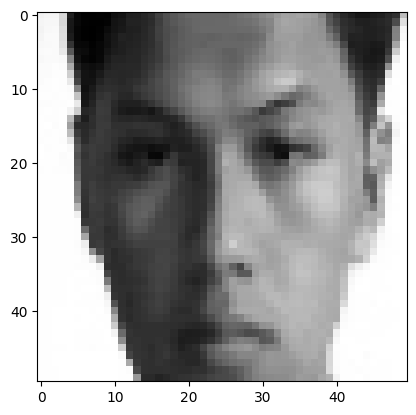

In [6]:
plt.imshow(images[1142], cmap="gray")

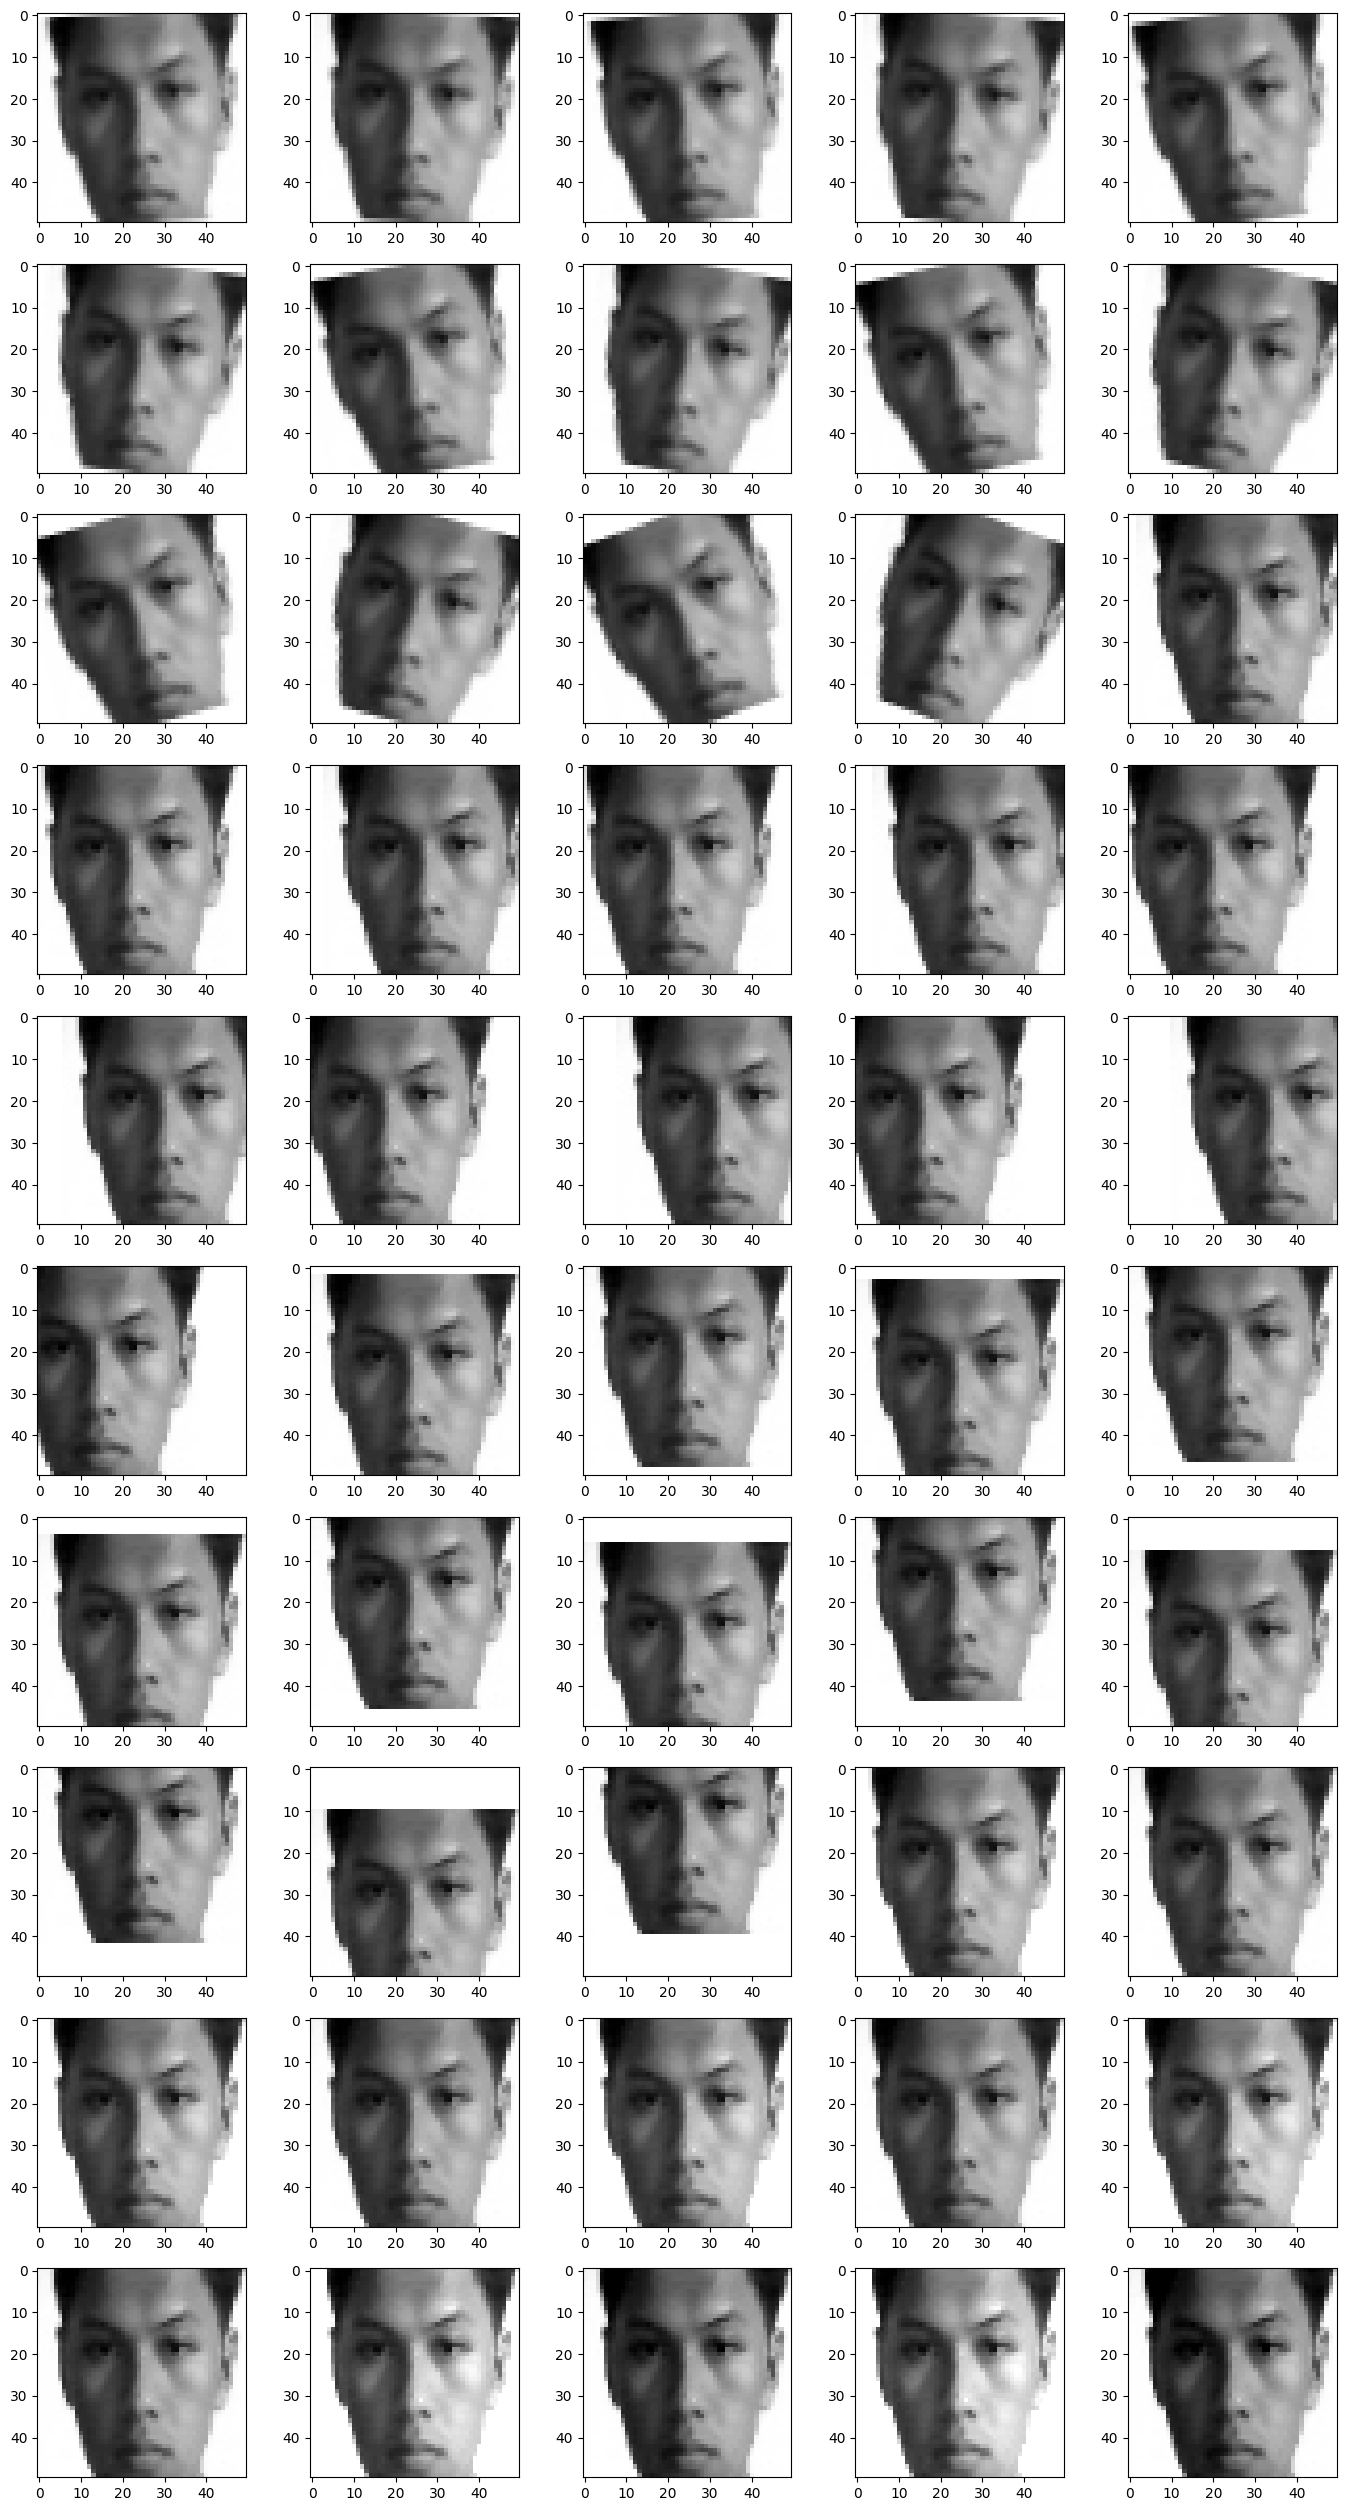

In [7]:
img_test = images[1142]
augmented_image_test = img_augmentation(img_test)
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(17, 32))

for ax, img in zip(axes.flatten(), augmented_image_test):
    ax.imshow(img, cmap="gray")

plt.show()


In [8]:
augmented_images = []
augmented_names = []
for i, img in enumerate(images):
    try :
        augmented_images.extend(img_augmentation(img))
        augmented_names.extend([names[i]] * 50)
    except :
        print(i)

In [9]:
len(augmented_images), len(augmented_names)

(90200, 90200)

In [10]:
images.extend(augmented_images)
names.extend(augmented_names)

In [11]:
len(images), len(names)

(92004, 92004)

In [12]:
unique, counts = np.unique(names, return_counts = True)

for item in zip(unique, counts):
    print(item)

('Ariel_Sharon', 3876)
('Colin_Powell', 11934)
('Donald_Rumsfeld', 6171)
('George_W_Bush', 26928)
('Gerhard_Schroeder', 5508)
('Hugo_Chavez', 3570)
('Husain_Ahmad_Faiq', 11577)
('Muhammad_Saifuddin_Mahfudz', 4080)
('Najib_Abdullah_Muqsith', 6069)
('Pak_Hary_Sabita', 4947)
('Tony_Blair', 7344)


### 1.4 Distribution and Balancing Data

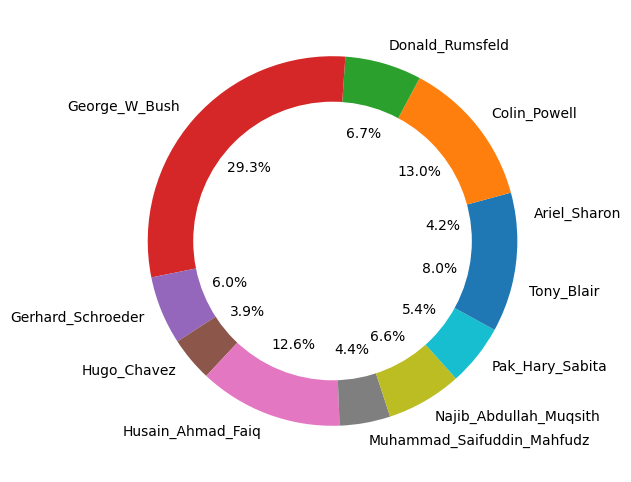

In [13]:
def print_data(label_distr, label_name):
    plt.figure(figsize=(12,6))

    my_circle = plt.Circle( (0,0), 0.75, color='white')
    plt.pie(label_distr, labels=label_name, autopct='%1.1f%%')
    plt.gcf().gca().add_artist(my_circle)
    plt.show()
    
unique = np.unique(names)
label_distr = {i:names.count(i) for i in names}.values()
print_data(label_distr, unique)

In [14]:
# reduce sample size per-class using numpy random choice
n = 3500

def randc(labels, l):
    return np.random.choice(np.where(np.array(labels) == l)[0], n, replace=False)

mask = np.hstack([randc(names, l) for l in np.unique(names)])

In [15]:
names = [names[m] for m in mask]
images = [images[m] for m in mask]

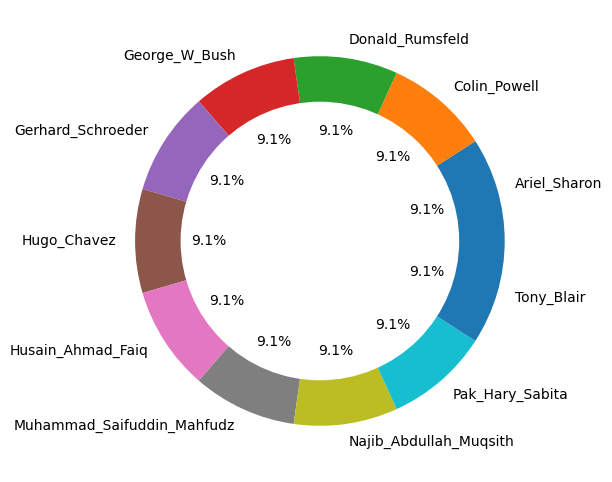

In [16]:
label_distr = {i:names.count(i) for i in names}.values()
print_data(label_distr, unique)

In [17]:
len(names)

38500

## 2. Label Encoding

In [18]:
le = LabelEncoder()

le.fit(names)

labels = le.classes_

name_vec = le.transform(names)

categorical_name_vec = to_categorical(name_vec)

In [19]:
print("number of class :", len(labels))
print(labels)

number of class : 11
['Ariel_Sharon' 'Colin_Powell' 'Donald_Rumsfeld' 'George_W_Bush'
 'Gerhard_Schroeder' 'Hugo_Chavez' 'Husain_Ahmad_Faiq'
 'Muhammad_Saifuddin_Mahfudz' 'Najib_Abdullah_Muqsith' 'Pak_Hary_Sabita'
 'Tony_Blair']


In [20]:
print(name_vec)

[ 0  0  0 ... 10 10 10]


In [21]:
print(categorical_name_vec)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


## 3. Data Test Split

In [22]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_idx, test_idx = next(sss.split(np.zeros(len(categorical_name_vec)), categorical_name_vec))

x_train = np.array(images)[train_idx]
y_train = categorical_name_vec[train_idx]
x_test = np.array(images)[test_idx]
y_test = categorical_name_vec[test_idx]

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [23]:
print(x_train.shape, y_train.shape, x_test.shape,  y_test.shape)

(34650, 50, 50, 1) (34650, 11) (3850, 50, 50, 1) (3850, 11)


In [24]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [25]:
x_train.shape, x_test.shape

((34650, 50, 50, 1), (3850, 50, 50, 1))

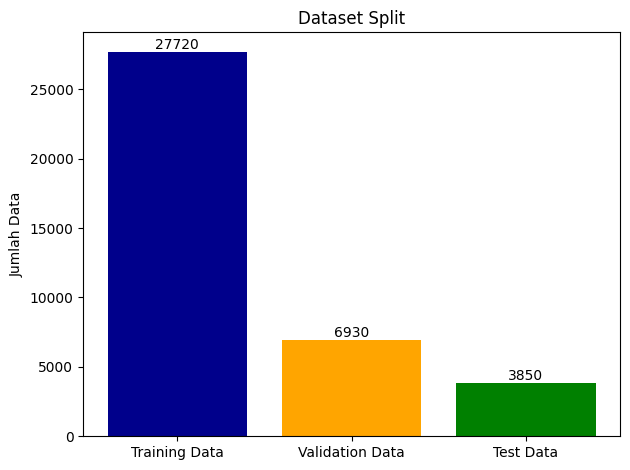

In [26]:
jenis_data = ['Training Data', 'Validation Data', 'Test Data']
validation_data = int(x_train.shape[0] * 0.2)
jumlah_data = [x_train.shape[0] - validation_data, validation_data, x_test.shape[0]]
colors = ['darkblue','orange', 'green']

plt.bar(jenis_data, jumlah_data, color=colors)
plt.title('Dataset Split')
plt.ylabel('Jumlah Data')

for i, v in enumerate(jumlah_data):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 4. Convolutional Neural Network (CNN) Model

In [52]:
def cnn_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32,
                     (3, 3),
                     name="Conv_1",
                     padding="same",
                     activation="relu",
                     input_shape=input_shape,
                     kernel_regularizer=regularizers.l2(1e-04)))
    
    model.add(Conv2D(64,
                     (3, 3),
                     name="Conv_2",
                     padding="same",
                     activation="relu",
                     input_shape=input_shape,
                     kernel_regularizer=regularizers.l2(1e-04)))

    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(128,
                     (3, 3),
                     name="Conv_3",
                     padding="same",
                     activation="relu",
                     kernel_regularizer=regularizers.l2(1e-04)))
    
    model.add(Conv2D(256,
                     (3, 3),
                     name="Conv_4",
                     padding="same",
                     activation="relu",
                     kernel_regularizer=regularizers.l2(1e-04)))

    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(256,
                    name="Dense_1",
                    activation="relu",
                    kernel_regularizer=regularizers.l2(1e-04)))
    
    model.add(Dropout(0.35))
    
    model.add(Dense(32,
                    name="Dense_2",
                    activation="relu",
                    kernel_regularizer=regularizers.l2(1e-04)))
    
    model.add(Dropout(0.35))
    
    model.add(Dense(len(labels)))

    model.add(Activation("softmax"))

    model.summary()

    optimizer = keras.optimizers.Adam(learning_rate=1e-04)
    loss = keras.losses.CategoricalCrossentropy()

    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])

    return model

## 5. Training Convolutional Neural Network (CNN) Model

In [53]:
input_shape = x_train[0].shape

EPOCHS = 20
BATCH_SIZE = 32

model = cnn_model(input_shape)

history = model.fit(x_train, 
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    validation_split=0.2   # 20 % of train dataset will be used as validation set
                    )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 50, 50, 32)        320       
                                                                 
 Conv_2 (Conv2D)             (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 Conv_3 (Conv2D)             (None, 25, 25, 128)       73856     
                                                                 
 Conv_4 (Conv2D)             (None, 25, 25, 256)       295168    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                  

## 6. Evaluate Convolutional Neural Network (CNN) Model

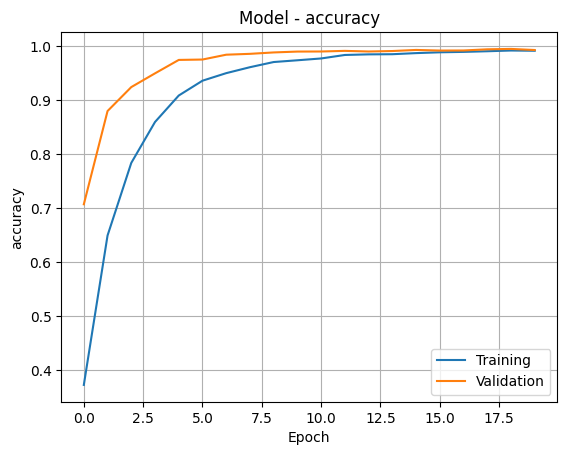

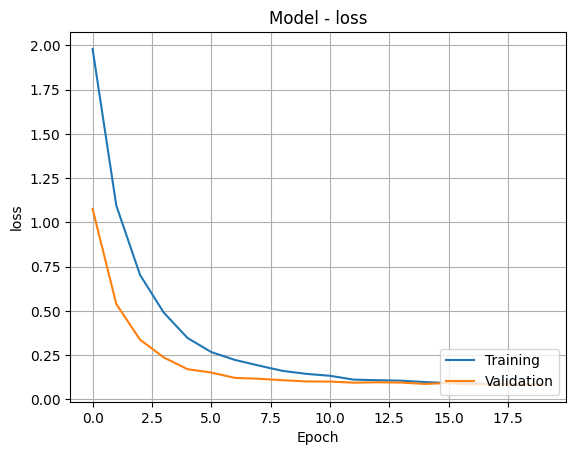

In [54]:
def evaluate_model_(history):
    names = [['accuracy', 'val_accuracy'], 
             ['loss', 'val_loss']]
    for name in names :
        fig1, ax_acc = plt.subplots()
        plt.plot(history.history[name[0]])
        plt.plot(history.history[name[1]])
        plt.xlabel('Epoch')
        plt.ylabel(name[0])
        plt.title('Model - ' + name[0])
        plt.legend(['Training', 'Validation'], loc='lower right')
        plt.grid()
        plt.show()
        
evaluate_model_(history)

In [55]:
model.save("model-cnn-facerecognition.h5")

In [56]:
model_test = load_model("model-cnn-facerecognition.h5")
model_test.evaluate(x_test, y_test)

121/121 [==============================] - 2s 12ms/step - loss: 0.1016 - accuracy: 0.9919


[0.1015600636601448, 0.9919480681419373]

## 7. Confusion Matrix for Convolutional Neural Network (CNN) Model

In [57]:
# predict test data
y_pred = model.predict(x_test)

121/121 [==============================] - 1s 10ms/step


In [58]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 8))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

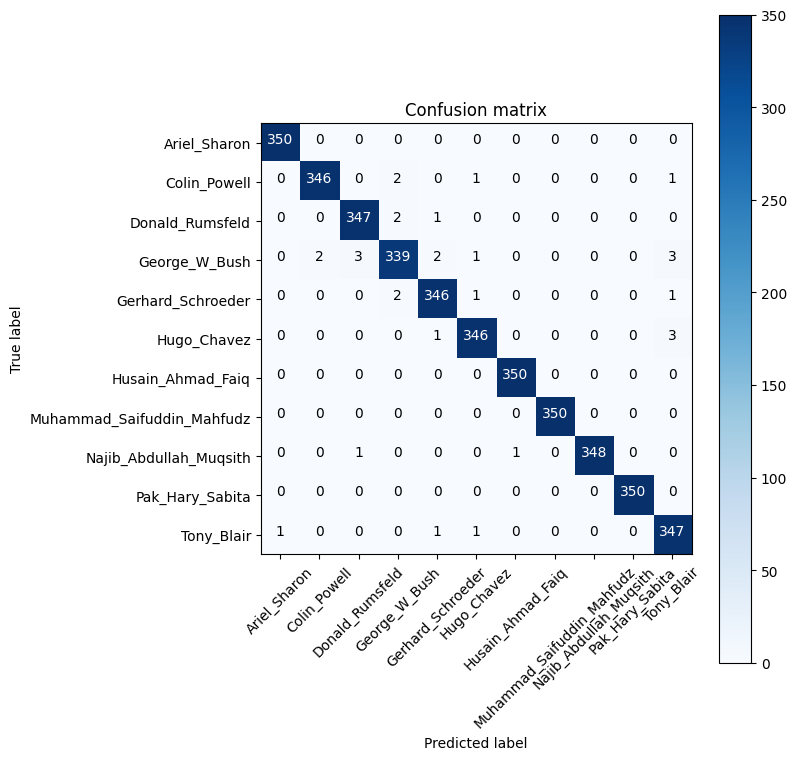

In [59]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels,normalize=False,
                      title='Confusion matrix')


## 8. Test Model with Video Frame

In [43]:
# Video frame using Haar Cascade OpenCV
def draw_ped(img, label, x0, y0, xt, yt, color=(255,0,0), text_color=(255,255,255)):

    (w, h), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    cv2.rectangle(img,
                  (x0, y0 + baseline),  
                  (max(xt, x0 + w), yt), 
                  color, 
                  2)
    cv2.rectangle(img,
                  (x0, y0 - h),  
                  (x0 + w, y0 + baseline), 
                  color, 
                  -1)  
    cv2.putText(img, 
                label, 
                (x0, y0),                   
                cv2.FONT_HERSHEY_SIMPLEX,     
                0.5,                          
                text_color,                
                1,
                cv2.LINE_AA) 
    return img


# --------- load Haar Cascade model -------------
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# --------- load Convolutional Neural Network (CNN model -------------
model = load_model("model-cnn-facerecognition.h5")
print("[INFO] finish load model...")

cap = cv2.VideoCapture(0)
while cap.isOpened() :
    ret, frame = cap.read()
    if ret:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)
        for (x, y, w, h) in faces:
            
            face_img = gray[y:y+h, x:x+w]
            face_img = cv2.resize(face_img, (50, 50))
            face_img = face_img.reshape(1, 50, 50, 1)
            
            result = model.predict(face_img)
            idx = result.argmax(axis=1)
            confidence = result.max(axis=1)*100
            if confidence > 98:
                label_text = "%s (%.2f %%)" % (labels[idx[0]], confidence[0])
                frame = draw_ped(frame, label_text, x, y, x + w, y + h, color=(0, 255, 0), text_color=(50, 50, 50))
            else :
                label_text = "Unknown"
                frame = draw_ped(frame, label_text, x, y, x + w, y + h, color=(0, 0, 255), text_color=(50, 50, 50))
       
        cv2.imshow('Detect Face', frame)
    else :
        break
    if cv2.waitKey(10) == ord('q'):
        break
        
cv2.destroyAllWindows()
cap.release()

[INFO] finish load model...
1/1 [==============================] - 0s 31ms/step


## 9. Cross-Validation Method

In [62]:
from sklearn.model_selection import KFold

In [63]:
def cnn_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32,
                     (3, 3),
                     name="Conv_1",
                     padding="same",
                     activation="relu",
                     input_shape=input_shape,
                      kernel_regularizer=regularizers.l2(1e-04)))
    
    model.add(Conv2D(64,
                     (3, 3),
                     name="Conv_2",
                     padding="same",
                     activation="relu",
                     input_shape=input_shape,
                     kernel_regularizer=regularizers.l2(1e-04)))

    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(128,
                     (3, 3),
                     name="Conv_3",
                     padding="same",
                     activation="relu",
                     kernel_regularizer=regularizers.l2(1e-04)))
    
    model.add(Conv2D(256,
                     (3, 3),
                     name="Conv_4",
                     padding="same",
                     activation="relu",
                     kernel_regularizer=regularizers.l2(1e-04)))

    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(256,
                    name="Dense_1",
                    activation="relu",
                    kernel_regularizer=regularizers.l2(1e-04)))
    
    model.add(Dropout(0.35))
    
    model.add(Dense(32,
                    name="Dense_2",
                    activation="relu",
                    kernel_regularizer=regularizers.l2(1e-04)))
    
    model.add(Dropout(0.35))
    
    model.add(Dense(len(labels)))

    model.add(Activation("softmax"))

    model.summary()

    optimizer = keras.optimizers.Adam(learning_rate=1e-04)
    loss = keras.losses.CategoricalCrossentropy()

    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])

    return model

In [64]:
EPOCHS = 20
BATCH_SIZE = 32

input_shape = x_train[0].shape

n_splits = 5
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)

evaluation_results = []
histories = []

for fold, (train_index, test_index) in enumerate(sss.split(x_train, y_train)):
    print(f"Training on Fold {fold + 1}...")
    x_train_fold, x_val_fold = x_train[train_index], x_train[test_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]

    # Clear the TensorFlow session and release GPU memory from the previous fold
    tf.keras.backend.clear_session()

    model = cnn_model(input_shape)
    
    history = model.fit(x_train_fold,
                        y_train_fold,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        validation_data=(x_val_fold, y_val_fold))
    
    histories.append(history)

    evaluation = model.evaluate(x_test, y_test)
    evaluation_results.append(evaluation)

    # Save the model for the current fold
    model.save(f"model_fold_{fold + 1}.h5")

Training on Fold 1...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 50, 50, 32)        320       
                                                                 
 Conv_2 (Conv2D)             (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 64)       0         
 )                                                               
                                                                 
 Conv_3 (Conv2D)             (None, 25, 25, 128)       73856     
                                                                 
 Conv_4 (Conv2D)             (None, 25, 25, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                              

 )                                                               
                                                                 
 Conv_3 (Conv2D)             (None, 25, 25, 128)       73856     
                                                                 
 Conv_4 (Conv2D)             (None, 25, 25, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 36864)             0         
                                                                 
 Dense_1 (Dense)             (None, 256)               9437440   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 Dense_2 (

### 9.1 Cross-Validation's 5-Fold Results

In [65]:
for fold, evaluation in enumerate(evaluation_results):
    print(f"Fold {fold + 1} - Loss: {evaluation[0]}, Accuracy: {evaluation[1]}")

Fold 1 - Loss: 0.0951789990067482, Accuracy: 0.9927272796630859
Fold 2 - Loss: 0.08260279893875122, Accuracy: 0.9940259456634521
Fold 3 - Loss: 0.0824093222618103, Accuracy: 0.9942857027053833
Fold 4 - Loss: 0.09219150245189667, Accuracy: 0.9893506765365601
Fold 5 - Loss: 0.09251967072486877, Accuracy: 0.991428554058075


### 9.2 Best Fold Result

In [66]:
average_accuracy = np.mean([evaluation[1] for evaluation in evaluation_results])
best_fold = np.argmax([evaluation[1] for evaluation in evaluation_results])

print(f"The best model is from Fold {best_fold + 1} with an average accuracy of {average_accuracy}.")


The best model is from Fold 3 with an average accuracy of 0.9923636317253113.


In [67]:
best_model = load_model(f"model_fold_{best_fold + 1}.h5")
test_evaluation = best_model.evaluate(x_test, y_test)
print(f"Test Loss: {test_evaluation[0]}, Test Accuracy: {test_evaluation[1]}")

121/121 [==============================] - 1s 8ms/step - loss: 0.0824 - accuracy: 0.9943
Test Loss: 0.0824093222618103, Test Accuracy: 0.9942857027053833


### 9.3 Confusion Matrix for Best Fold

In [68]:
# predict test data
y_pred = best_model.predict(x_test)

121/121 [==============================] - 1s 7ms/step


In [69]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 8))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

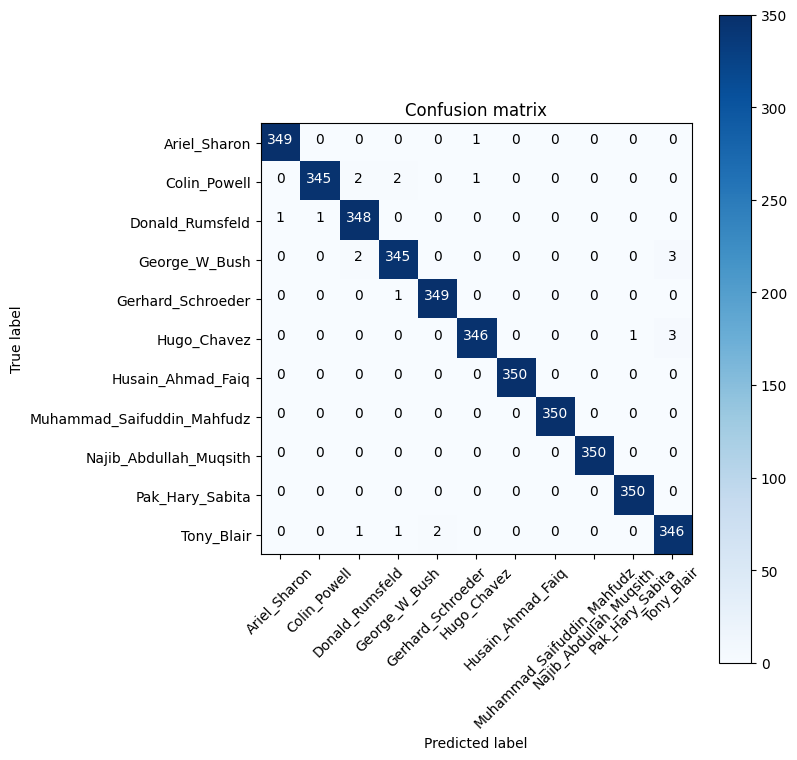

In [70]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels,normalize=False,
                      title='Confusion matrix')


### 9.4 Evaluate 5-Fold Results

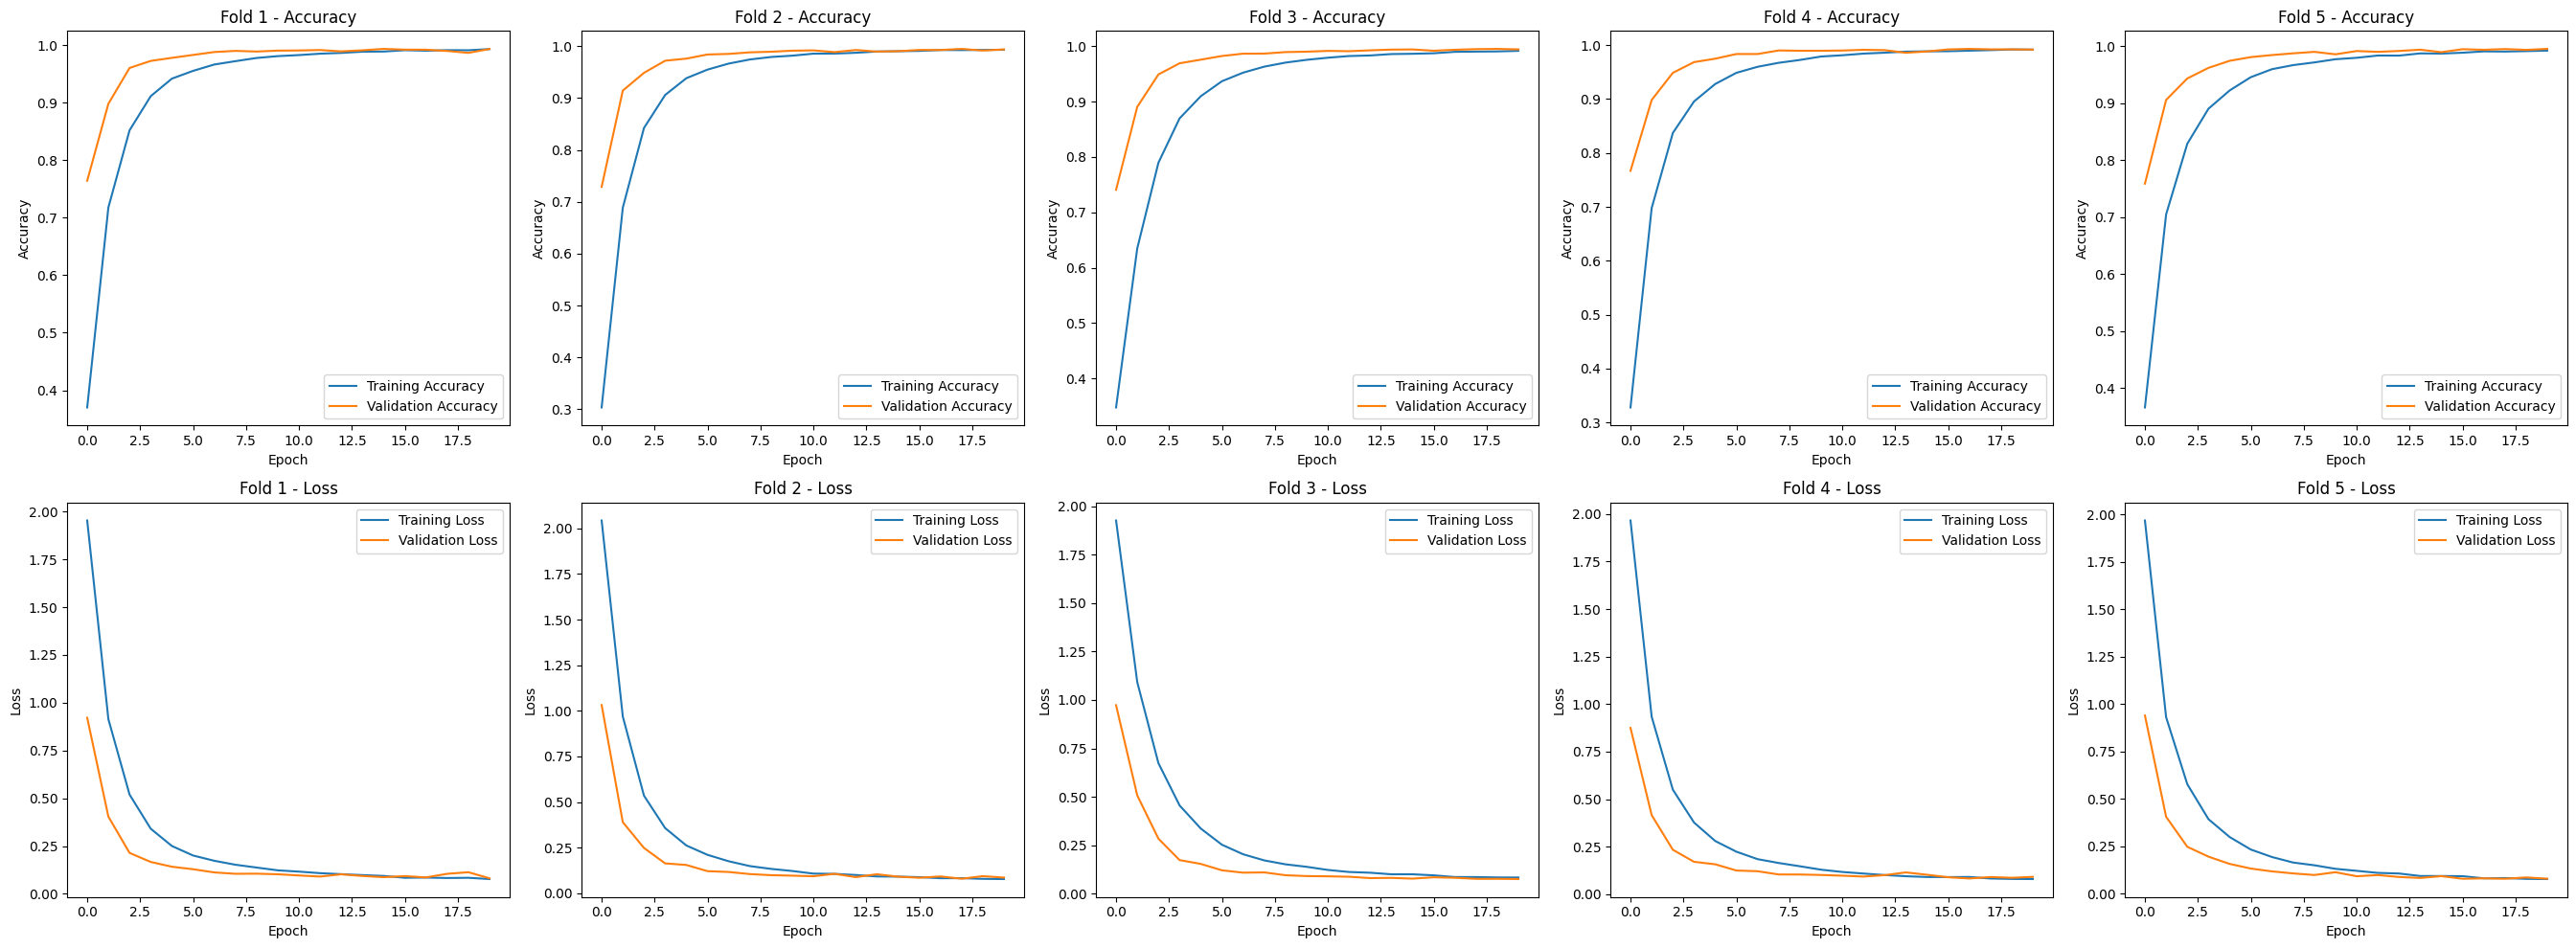

In [71]:
plt.figure(figsize=(27, 10))
for fold, history in enumerate(histories):
    plt.subplot(2, n_splits, fold + 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, n_splits, n_splits + fold + 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold + 1} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()

### 9.5 Test Best Fold with Video Frame

In [72]:
# Video frame using Haar Cascade OpenCV
def draw_ped(img, label, x0, y0, xt, yt, color=(255,0,0), text_color=(255,255,255)):

    (w, h), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    cv2.rectangle(img,
                  (x0, y0 + baseline),  
                  (max(xt, x0 + w), yt), 
                  color, 
                  2)
    cv2.rectangle(img,
                  (x0, y0 - h),  
                  (x0 + w, y0 + baseline), 
                  color, 
                  -1)  
    cv2.putText(img, 
                label, 
                (x0, y0),                   
                cv2.FONT_HERSHEY_SIMPLEX,     
                0.5,                          
                text_color,                
                1,
                cv2.LINE_AA) 
    return img


# --------- load Haar Cascade model -------------
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# --------- load Convolutional Neural Network (CNN model -------------
model = load_model(f"model_fold_{best_fold + 1}.h5")
print("[INFO] finish load model...")

cap = cv2.VideoCapture(0)
while cap.isOpened() :
    ret, frame = cap.read()
    if ret:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)
        for (x, y, w, h) in faces:
            
            face_img = gray[y:y+h, x:x+w]
            face_img = cv2.resize(face_img, (50, 50))
            face_img = face_img.reshape(1, 50, 50, 1)
            
            result = model.predict(face_img)
            idx = result.argmax(axis=1)
            confidence = result.max(axis=1)*100
            if confidence > 98:
                label_text = "%s (%.2f %%)" % (labels[idx[0]], confidence[0])
                frame = draw_ped(frame, label_text, x, y, x + w, y + h, color=(0, 255, 0), text_color=(50, 50, 50))
            else :
                label_text = "Unknown"
                frame = draw_ped(frame, label_text, x, y, x + w, y + h, color=(0, 0, 255), text_color=(50, 50, 50))
       
        cv2.imshow('Detect Face', frame)
    else :
        break
    if cv2.waitKey(10) == ord('q'):
        break
        
cv2.destroyAllWindows()
cap.release()

[INFO] finish load model...
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


## 10. Deep Neural Network (DNN) Model

In [39]:
def dnn_model(input_shape):
    model = Sequential()

    model.add(Flatten(input_shape=input_shape))
    
    model.add(Dense(1024,
                    activation="relu",
                    kernel_regularizer=regularizers.l2(1e-05)))
    
    model.add(Dense(1024,
                    activation="relu",
                    kernel_regularizer=regularizers.l2(1e-05)))
    
    model.add(Dense(512,
                    activation="relu",
                    kernel_regularizer=regularizers.l2(1e-05)))
    
    model.add(Dense(512,
                    activation="relu",
                    kernel_regularizer=regularizers.l2(1e-05)))
    
    model.add(Dense(256,
                    activation="relu",
                    kernel_regularizer=regularizers.l2(1e-05)))
    
    model.add(Dense(256,
                    activation="relu",
                    kernel_regularizer=regularizers.l2(1e-05)))
    
    model.add(Dense(128,
                    activation="relu",
                    kernel_regularizer=regularizers.l2(1e-05)))
    
    model.add(Dense(128,
                    activation="relu",
                    kernel_regularizer=regularizers.l2(1e-05)))
    
    model.add(Dense(64,
                    activation="relu",
                    kernel_regularizer=regularizers.l2(1e-05)))
    
    model.add(Dense(64,
                    activation="relu",
                    kernel_regularizer=regularizers.l2(1e-05)))
    
    model.add(Dense(32,
                    activation="relu",
                    kernel_regularizer=regularizers.l2(1e-05)))
    
    model.add(Dense(32,
                    activation="relu",
                    kernel_regularizer=regularizers.l2(1e-05)))
    
    model.add(Dense(16,
                    activation="relu",
                    kernel_regularizer=regularizers.l2(1e-05)))
    
    model.add(Dense(16,
                    activation="relu",
                    kernel_regularizer=regularizers.l2(1e-05)))

    model.add(Dense(len(labels)))

    model.add(Activation("softmax"))

    model.summary()

    optimizer = keras.optimizers.Adam(learning_rate=1e-04)
    loss = keras.losses.CategoricalCrossentropy()

    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])

    return model

### 10.1 Training Deep Neural Network (DNN) Model

In [40]:
input_shape = x_train[0].shape

EPOCHS = 50
BATCH_SIZE = 16

model = dnn_model(input_shape)

history = model.fit(x_train, 
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    validation_split=0.2   # 20 % of train dataset will be used as validation set
                    )

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 2500)              0         
                                                                 
 dense_30 (Dense)            (None, 1024)              2561024   
                                                                 
 dense_31 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_32 (Dense)            (None, 512)               524800    
                                                                 
 dense_33 (Dense)            (None, 512)               262656    
                                                                 
 dense_34 (Dense)            (None, 256)               131328    
                                                                 
 dense_35 (Dense)            (None, 256)              

Epoch 39/50
1733/1733 [==============================] - 10s 6ms/step - loss: 0.2594 - accuracy: 0.9592 - val_loss: 0.3758 - val_accuracy: 0.9304
Epoch 40/50
1733/1733 [==============================] - 11s 6ms/step - loss: 0.2625 - accuracy: 0.9593 - val_loss: 0.3519 - val_accuracy: 0.9361
Epoch 41/50
1733/1733 [==============================] - 11s 6ms/step - loss: 0.2521 - accuracy: 0.9601 - val_loss: 0.3999 - val_accuracy: 0.9165
Epoch 42/50
1733/1733 [==============================] - 10s 6ms/step - loss: 0.2493 - accuracy: 0.9630 - val_loss: 0.4048 - val_accuracy: 0.9251
Epoch 43/50
1733/1733 [==============================] - 10s 6ms/step - loss: 0.2398 - accuracy: 0.9658 - val_loss: 0.3581 - val_accuracy: 0.9348
Epoch 44/50
1733/1733 [==============================] - 11s 6ms/step - loss: 0.2429 - accuracy: 0.9646 - val_loss: 0.3936 - val_accuracy: 0.9208
Epoch 45/50
1733/1733 [==============================] - 10s 6ms/step - loss: 0.2378 - accuracy: 0.9669 - val_loss: 0.3620 -

### 10.2 Evaluate Deep Neural Network (DNN) Model

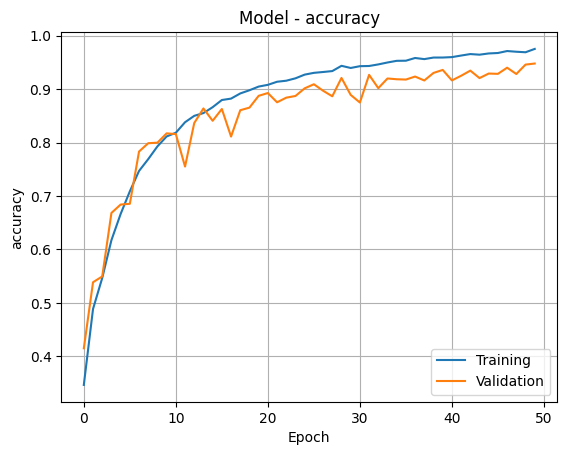

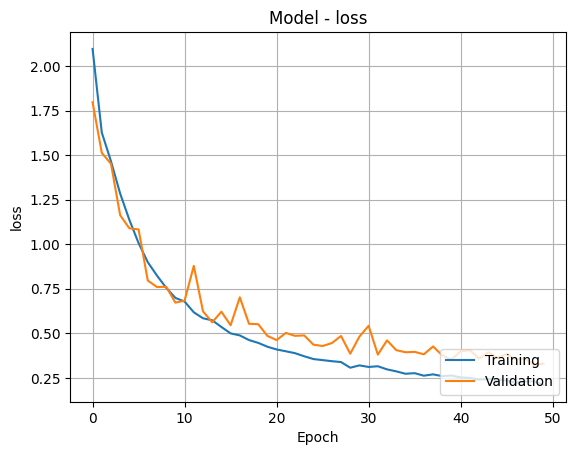

In [41]:
def evaluate_model_(history):
    names = [['accuracy', 'val_accuracy'], 
             ['loss', 'val_loss']]
    for name in names :
        fig1, ax_acc = plt.subplots()
        plt.plot(history.history[name[0]])
        plt.plot(history.history[name[1]])
        plt.xlabel('Epoch')
        plt.ylabel(name[0])
        plt.title('Model - ' + name[0])
        plt.legend(['Training', 'Validation'], loc='lower right')
        plt.grid()
        plt.show()
        
evaluate_model_(history)

In [42]:
model.save("model-dnn-facerecognition.h5")

In [43]:
model_test = load_model("model-dnn-facerecognition.h5")

In [44]:
model_test.evaluate(x_test, y_test)

121/121 [==============================] - 1s 3ms/step - loss: 0.3210 - accuracy: 0.9483


[0.32103192806243896, 0.9483116865158081]

### 10.3 Confusion Matrix for Deep Neural Network (DNN) Model

In [46]:
# predict test data
y_pred = model.predict(x_test)

121/121 [==============================] - 0s 4ms/step


In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 8))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

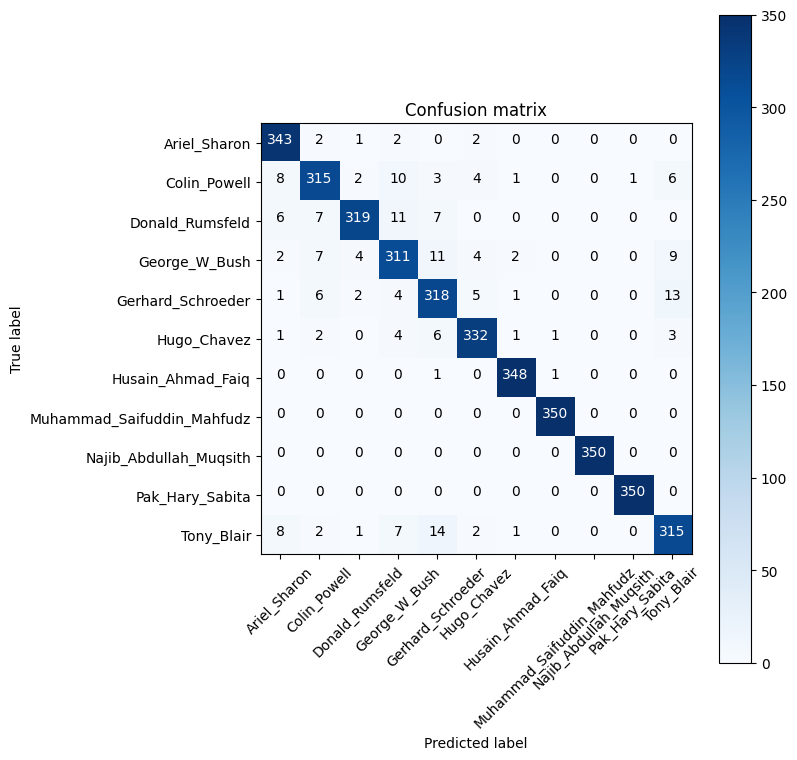

In [48]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels,normalize=False,
                      title='Confusion matrix')


### 10.3 Test Model with Video Frame

In [45]:
# Video frame using Haar Cascade OpenCV
def draw_ped(img, label, x0, y0, xt, yt, color=(255,0,0), text_color=(255,255,255)):

    (w, h), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    cv2.rectangle(img,
                  (x0, y0 + baseline),  
                  (max(xt, x0 + w), yt), 
                  color, 
                  2)
    cv2.rectangle(img,
                  (x0, y0 - h),  
                  (x0 + w, y0 + baseline), 
                  color, 
                  -1)  
    cv2.putText(img, 
                label, 
                (x0, y0),                   
                cv2.FONT_HERSHEY_SIMPLEX,     
                0.5,                          
                text_color,                
                1,
                cv2.LINE_AA) 
    return img


# --------- load Haar Cascade model -------------
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# --------- load Deep Neural Network (DNN) model -------------
model = load_model("model-dnn-facerecognition.h5")
print("[INFO] finish load model...")

cap = cv2.VideoCapture(0)
while cap.isOpened() :
    ret, frame = cap.read()
    if ret:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)
        for (x, y, w, h) in faces:
            
            face_img = gray[y:y+h, x:x+w]
            face_img = cv2.resize(face_img, (50, 50))
            face_img = face_img.reshape(1, 50, 50, 1)
            
            result = model.predict(face_img)
            idx = result.argmax(axis=1)
            confidence = result.max(axis=1)*100
            if confidence > 75:
                label_text = "%s (%.2f %%)" % (labels[idx[0]], confidence[0])
                frame = draw_ped(frame, label_text, x, y, x + w, y + h, color=(0, 255, 0), text_color=(50, 50, 50))
            else :
                label_text = "Unknown"
                frame = draw_ped(frame, label_text, x, y, x + w, y + h, color=(0, 0, 255), text_color=(50, 50, 50))
       
        cv2.imshow('Detect Face', frame)
    else :
        break
    if cv2.waitKey(10) == ord('q'):
        break
        
cv2.destroyAllWindows()
cap.release()

[INFO] finish load model...
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


## 11. Hyperparameter Tuning Convolutional Neural Network (CNN) Model

In [73]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

In [74]:
input_shape = x_train[0].shape


def model_builder(hp):
    model = Sequential()

    model.add(Conv2D(32,
                     name="Conv_1",
                     kernel_size=(3, 3),
                     padding="valid",
                     activation="relu",
                     input_shape=input_shape,
                     kernel_regularizer=regularizers.l2(hp.Choice('l2_regularization',
                                                                  values=[1e-02, 1e-03, 1e-04]))))
    
    model.add(Conv2D(64,
                     name="Conv_2",
                     kernel_size=(3, 3),
                     padding="valid",
                     activation="relu",
                     input_shape=input_shape,
                     kernel_regularizer=regularizers.l2(hp.Choice('l2_regularization',
                                                                  values=[1e-02, 1e-03, 1e-04]))))

    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(128,
                     name="Conv_3",
                     kernel_size=(3, 3),
                     padding="valid",
                     activation="relu",
                     kernel_regularizer=regularizers.l2(hp.Choice('l2_regularization',
                                                                  values=[1e-02, 1e-03, 1e-04]))))
    
    model.add(Conv2D(256,
                     name="Conv_4",
                     kernel_size=(3, 3),
                     padding="valid",
                     activation="relu",
                     kernel_regularizer=regularizers.l2(hp.Choice('l2_regularization',
                                                                  values=[1e-02, 1e-03, 1e-04]))))

    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(256,
                    name="Dense_1",
                    activation="relu",
                    kernel_regularizer=regularizers.l2(hp.Choice('l2_regularization',
                                                                 values=[1e-02, 1e-03, 1e-04]))))
    
    model.add(Dropout(hp.Float('dropout_rate_1',
                               min_value=0.1,
                               max_value=0.5,
                               step=0.05)))
    
    model.add(Dense(32,
                    name="Dense_2",
                    activation="relu",
                    kernel_regularizer=regularizers.l2(hp.Choice('l2_regularization',
                                                                 values=[1e-02, 1e-03, 1e-04]))))
    
    model.add(Dropout(hp.Float('dropout_rate_2',
                               min_value=0.1,
                               max_value=0.5,
                               step=0.05)))
    
    model.add(Dense(len(labels), activation="softmax"))

    optimizer = keras.optimizers.Adam(learning_rate=1e-04)
    loss = keras.losses.CategoricalCrossentropy()
    
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])

    return model


In [75]:
def tune_hyperparameters(max_trials):
    tuner = kt.RandomSearch(
        model_builder,
        objective='val_loss',
        max_trials=max_trials,
        directory='hyperparameter_tuning',
        project_name='face_recognition')
    
    while len(tuner.oracle.trials) < max_trials:
        tuner.reload()
        
        tuner.search(x_train,
                     y_train,
                     epochs=20,
                     batch_size=32,
                     validation_split=0.2) 
        
        if tuner.oracle.get_best_trials(1)[0].status == 'COMPLETED':
            break
   
    best_model = tuner.get_best_models(num_models=1)[0]

    test_loss, test_accuracy = best_model.evaluate(x_test, y_test)
    print('Test Loss:', test_loss)
    print('Test Accuracy:', test_accuracy)
    
    tuner.results_summary()
    
    return best_model

In [76]:
hp = kt.HyperParameters()
model_builder(hp)

### 11.1 Hyperparameter Tuning Trails

In [80]:
best_model = tune_hyperparameters(max_trials=35)

Trial 35 Complete [00h 05m 44s]
val_loss: 0.36584359407424927

Best val_loss So Far: 0.06142796576023102
Total elapsed time: 00h 28m 35s
INFO:tensorflow:Oracle triggered exit
121/121 [==============================] - 1s 7ms/step - loss: 0.1089 - accuracy: 0.9826
Test Loss: 0.10886169970035553
Test Accuracy: 0.9825974106788635
Results summary
Results in hyperparameter_tuning\face_recognition
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 16 summary
Hyperparameters:
l2_regularization: 0.0001
dropout_rate_1: 0.25
dropout_rate_2: 0.2
Score: 0.06142796576023102

Trial 05 summary
Hyperparameters:
l2_regularization: 0.0001
dropout_rate_1: 0.1
dropout_rate_2: 0.25
Score: 0.0650591179728508

Trial 2 summary
Hyperparameters:
l2_regularization: 0.0001
dropout_rate_1: 0.2
dropout_rate_2: 0.1
Score: 0.06523200869560242

Trial 17 summary
Hyperparameters:
l2_regularization: 0.0001
dropout_rate_1: 0.30000000000000004
dropout_rate_2: 0.35
Score: 0.06697758287191391

Trial 07

### 11.2 Best Result Summary

In [78]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 Conv_2 (Conv2D)             (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 Conv_3 (Conv2D)             (None, 21, 21, 128)       73856     
                                                                 
 Conv_4 (Conv2D)             (None, 19, 19, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 256)        0         
 2D)                                                    